In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split

# Load data

In [385]:
hospital_data = pd.read_csv('hospital_mortality.csv')
hospital_data


,PATIENT_ID,Age,Gender,Height,ICUType,BUN_Min,Creatinine_Min,GCS_Min,Glucose_Min,HCO3_Min,HCT_Min,HR_Min,K_Min,Mg_Min,NIDiasABP_Min,NIMAP_Min,NISysABP_Min,Na_Min,PaCO2_Min,PaO2_Min,Platelets_Min,Temp_Min,Urine_Min,WBC_Min,Weight_Min,pH_Min,BUN_Max,Creatinine_Max,GCS_Max,Glucose_Max,HCO3_Max,HCT_Max,HR_Max,K_Max,Mg_Max,NIDiasABP_Max,NIMAP_Max,NISysABP_Max,Na_Max,PaCO2_Max,...,Glucose_Median,HCO3_Median,HCT_Median,HR_Median,K_Median,Mg_Median,NIDiasABP_Median,NIMAP_Median,NISysABP_Median,Na_Median,PaCO2_Median,PaO2_Median,Platelets_Median,Temp_Median,Urine_Median,WBC_Median,Weight_Median,pH_Median,BUN_Range,Creatinine_Range,GCS_Range,Glucose_Range,HCO3_Range,HCT_Range,HR_Range,K_Range,Mg_Range,NIDiasABP_Range,NIMAP_Range,NISysABP_Range,Na_Range,PaCO2_Range,PaO2_Range,Platelets_Range,Temp_Range,Urine_Range,WBC_Range,Weight_Range,pH_Range,In-hospital_death
0,132539.0,54.0,0.0,-1.0,4.0,8.0,0.7,14.0,115.0,26.0,30.3,58.0,4.0,1.5,39.0,58.67,96.0,136.0,NaN,NaN,185.0,35.1,0.0,9.4,-1.0,NaN,13.0,0.8,15.0,205.0,28.0,33.7,86.0,4.4,1.9,67.0,92.33,157.0,137.0,NaN,...,160.0,27.0,33.50,73.0,4.20,1.70,49.0,70.000,110.0,136.5,NaN,NaN,203.0,37.70,100.0,10.30,-1.0,NaN,5.0,0.1,1.0,90.0,2.0,3.4,28.0,0.4,0.4,28.0,33.66,61.0,1.0,NaN,NaN,36.0,3.1,900.0,1.8,0.0,NaN,0
1,132540.0,76.0,1.0,175.3,2.0,16.0,0.8,3.0,105.0,21.0,24.7,65.0,3.5,1.9,38.0,49.33,72.0,135.0,33.0,82.0,135.0,34.5,0.0,7.4,76.0,7.34,21.0,1.3,15.0,146.0,24.0,30.7,90.0,4.3,3.1,67.0,88.33,131.0,139.0,46.0,...,125.5,22.0,28.80,80.0,3.90,2.10,59.0,78.165,115.0,137.0,40.0,153.0,181.0,37.45,90.0,13.10,80.6,7.40,5.0,0.5,12.0,41.0,3.0,6.0,25.0,0.8,1.2,29.0,39.00,59.0,4.0,13.0,363.0,91.0,3.4,770.0,5.9,5.6,0.11,0
2,132541.0,44.0,0.0,-1.0,3.0,3.0,0.3,5.0,119.0,24.0,26.7,57.0,2.3,1.3,66.0,83.33,111.0,137.0,33.0,65.0,72.0,36.7,18.0,3.7,56.7,7.47,8.0,0.4,8.0,143.0,26.0,29.4,113.0,8.6,1.9,95.0,110.00,150.0,140.0,37.0,...,141.0,25.0,28.70,85.5,3.40,1.80,79.0,97.670,134.0,138.0,36.0,120.5,84.0,37.85,100.0,4.20,56.7,7.50,5.0,0.1,3.0,24.0,2.0,2.7,56.0,6.3,0.6,29.0,26.67,39.0,3.0,4.0,167.0,41.0,2.3,407.0,2.5,0.0,0.04,0
3,132543.0,68.0,1.0,180.3,3.0,10.0,0.7,14.0,106.0,27.0,36.1,57.0,3.8,1.9,45.0,68.33,102.0,137.0,NaN,NaN,284.0,35.1,100.0,7.9,84.6,NaN,23.0,0.9,15.0,129.0,28.0,41.3,88.0,4.2,2.1,81.0,100.70,140.0,141.0,NaN,...,117.0,28.0,36.80,74.0,4.00,2.10,64.0,83.670,120.0,140.0,NaN,NaN,315.0,36.40,625.0,8.80,84.6,NaN,13.0,0.2,1.0,23.0,1.0,5.2,31.0,0.4,0.2,36.0,32.37,38.0,4.0,NaN,NaN,107.0,1.9,600.0,3.6,0.0,NaN,0
4,132545.0,88.0,0.0,-1.0,3.0,25.0,1.0,15.0,92.0,18.0,22.6,65.0,3.8,1.5,26.0,52.33,105.0,139.0,NaN,NaN,97.0,35.8,16.0,3.8,-1.0,NaN,45.0,1.0,15.0,113.0,20.0,32.4,94.0,6.0,1.6,96.0,105.70,157.0,140.0,NaN,...,102.5,19.0,30.60,73.0,3.90,1.55,42.0,75.330,131.0,139.5,NaN,NaN,103.0,37.00,50.0,4.30,-1.0,NaN,20.0,0.0,0.0,21.0,2.0,9.8,29.0,2.2,0.1,70.0,53.37,52.0,1.0,NaN,NaN,12.0,2.0,204.0,1.0,0.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,142665.0,70.0,0.0,-1.0,4.0,14.0,0.8,3.0,106.0,21.0,26.9,83.0,2.4,1.0,40.0,60.00,88.0,136.0,38.0,76.0,198.0,35.5,15.0,11.5,87.0,7.35,18.0,1.0,15.0,136.0,22.0,31.6,113.0,4.7,2.0,87.0,104.00,138.0,138.0,43.0,...,121.0,21.5,29.05,99.5,3.85,1.70,62.5,78.000,109.5,136.0,40.0,140.0,208.0,37.10,40.0,14.50,87.0,7.38,4.0,0.2,12.0,30.0,1.0,4.7,30.0,2.3,1.0,47.0,44.00,50.0,2.0,5.0,129.0,20.0,2.3,135.0,6.0,0.0,0.07,0
3996,142667.0,25.0,1.0,-1.0,3.0,3.0,0.7,15.0,65.0,20.0,30.3,59.0,3.4,1.3,38.0,61.67,109.0,138.0,NaN,NaN,118.0,35.5,400.0,3.0,166.4,NaN,7.0,0.9,15.0,251.0,28.0,31.9,106.0,4.1,1.5,78.0,100.70,151.0,142.0,NaN,...,96.0,23.0,31.80,79.0,3.70,1.50,58.5,81.835,125.5,141.0,NaN,NaN,118.0,36.70,575.0,4.70,166.4,NaN,4.0,0.2,0.0,186.0,8.0,1.6,47.0,0.7,0.2,40.0,39.03,42.0,4.0,NaN,NaN,37.0,1.9,500.0,3

### How many patients have 20 or more missing feature values? 

In [81]:
count = 0
for i in range(len(hospital_data.index)):
  if hospital_data.iloc[i].isnull().sum() >=20:
    count+=1
print("The number of patients having 20 or more missing features is %d" %count)



The number of patients having 20 or more missing features is 210


### What’s the difference in means of HR_min for patients that died vs survived (not counting patients with HR_min of  0)?

In [82]:
hospital_data['HR_Min'] = hospital_data['HR_Min'].fillna(0)
count_death = 0
count_alive = 0
mean_death = 0
mean_alive = 0
for i in range(len(hospital_data.index)):
  if hospital_data['In-hospital_death'][i]==0 and hospital_data['HR_Min'][i]!=0:
    mean_alive+=hospital_data['HR_Min'][i]
    count_alive+=1
  elif hospital_data['In-hospital_death'][i]==1 and hospital_data['HR_Min'][i]!=0:
    mean_death+=hospital_data['HR_Min'][i]
    count_death+=1
diff = abs((mean_alive/count_alive)-(mean_death/count_death))
print("The difference of means of HR_min for patients that died vs survived is %f" %diff)



The difference of means of HR_min for patients that died vs survived is 1.674645


### What is the median maximum heart rate for patients whose maximum temperature was 2 degrees Celsius higher than their minimum temperature?

In [83]:
from statistics import median
hospital_data['Temp_Min'] = hospital_data['Temp_Min'].fillna(0)
hospital_data['Temp_Max'] = hospital_data['Temp_Max'].fillna(0)
med = []
for i in range(len(hospital_data.index)):
  if hospital_data['Temp_Max'][i]>hospital_data['Temp_Min'][i]+2:
    med.append(hospital_data['HR_Max'][i])
print("Median maximum heart rate is %.03f"%median(med))

Median maximum heart rate is 113.000


### Create a plot to analyze the relationship between median temperature, outcome (died vs. survived), and age.

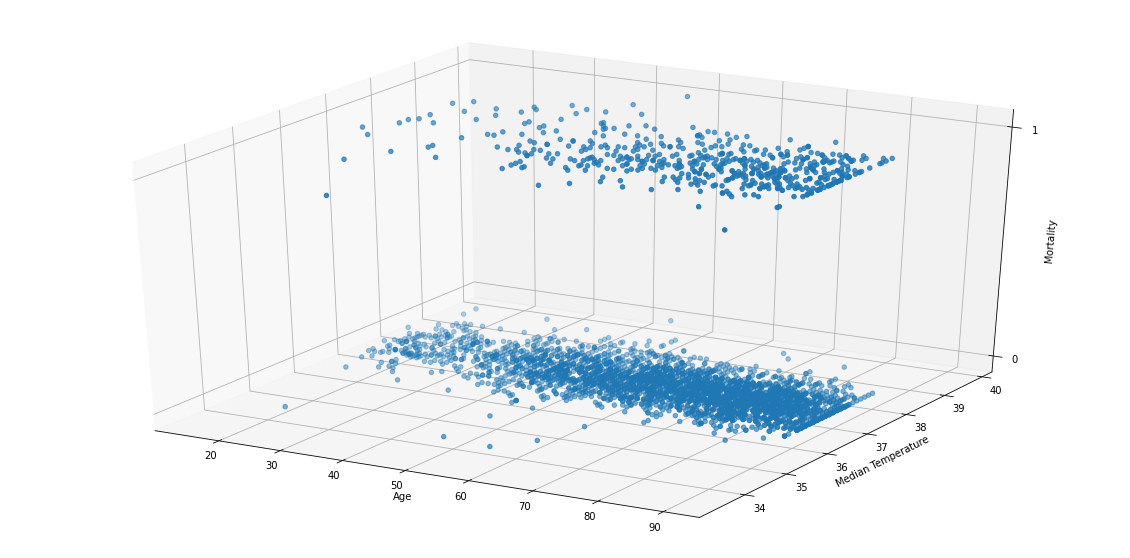

In [84]:
hospital_data = hospital_data[hospital_data.Temp_Median.notnull()]
chart_data = pd.concat([
	hospital_data['Temp_Median'],
	hospital_data['In-hospital_death'],
	hospital_data['Age'],
], axis=1)
fig = plt.figure(figsize = (20,10))
ax = plt.axes(projection='3d')
ax.scatter3D(chart_data['Age'],chart_data['Temp_Median'],chart_data['In-hospital_death'])
ax.set_xlabel('Age')
ax.set_ylabel('Median Temperature')
ax.set_zlabel('Mortality')
ax.set_zticks([0,1])

### Create a plot to analyze the relationship between median temperature, outcome (died vs. survived), and gender.

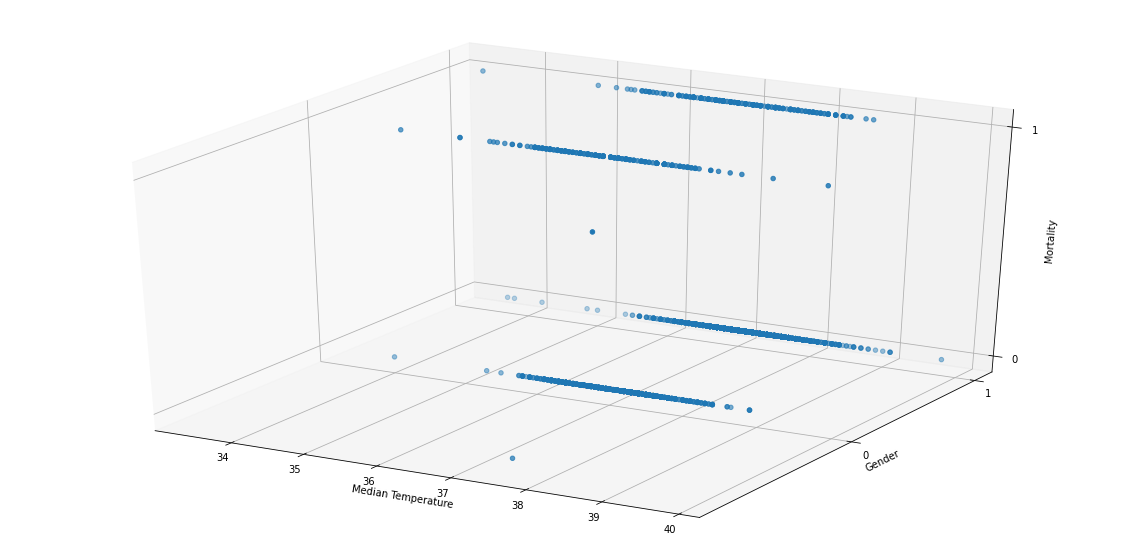

In [85]:
hospital_data = hospital_data[hospital_data.Temp_Median.notnull()]
chart_data = pd.concat([
	hospital_data['Temp_Median'],
	hospital_data['In-hospital_death'],
	hospital_data['Gender'],
], axis=1)
fig = plt.figure(figsize = (20,10))
ax = plt.axes(projection='3d')
ax.scatter3D(chart_data['Temp_Median'],chart_data['Gender'],chart_data['In-hospital_death'])
ax.set_ylabel('Gender')
ax.set_xlabel('Median Temperature')
ax.set_zlabel('Mortality')
ax.set_zticks([0,1])
ax.set_yticks([0,1])

### Build and summarize the results of a machine learning model that predicts whether a patient dies or survives in the hospital. (We do not expect a perfect or highest-accuracy solution; this is primarily an opportunity for you to show your machine learning project workflow and to document your thought process, approach to solving problems, and interpretation of results.)

In [429]:
"""
The column pH_Range has ~25% missing values which may effect the whole performance of the model.
So, the column has been dropped.
There are some garbage values and null values in few columns which have been replaced by mean of that column.
To prevent data leakage, train and test are split first before replacing null and garbage values with mean scores of the columns.
Feature selection has been done using Pearson Correlation and only the best features have been selected which have correlation > 0.1.
The test size is 20% of the whole data which is selected at random
"""
df = hospital_data
df = df.drop(columns=['pH_Range'])
train,test = train_test_split(df,test_size = 0.2)
train = train.replace(-1,np.nan)
train = train.fillna(train.mean())
test = test.replace(-1,np.nan)
test = test.fillna(train.mean())
temp = train["In-hospital_death"]
target_train = []
for i in temp:
  target_train.append(i)
temp = test["In-hospital_death"]
target_test = []
for i in temp:
  target_test.append(i)
cor = train.corr()
cor_target = cor["In-hospital_death"]
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1]
relevant_features = relevant_features.to_frame()


In [430]:
indices = []
for i in relevant_features.index:
  indices.append(i)
for i in train:
  if i not in indices:
    train = train.drop(columns=[i])
train = train.drop(columns = ["In-hospital_death"])
for i in test:
  if i not in indices:
    test = test.drop(columns=[i])
test = test.drop(columns = ["In-hospital_death"])


In [431]:
"""
There is a data imbalance which requires synthetic data augmentation.
I have used SMOTE to add synthetic data in order to balance the data while training.
"""
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from collections import Counter
oversample = SMOTE()
train, target_train = oversample.fit_resample(train, target_train)
test = np.asarray(test)
target_test = np.asarray(target_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [432]:
"""
For classification, XGBoost classifier is used.
It uses boosted trees for classification which is an ensemble.
In general, ensembles work better than a single entity.
"""
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score
model = XGBClassifier()
model.fit(train, target_train)
acc = accuracy_score(target_test,model.predict(test))
print("Accuracy on test set is %f" %acc)
print("AUC is %f"%roc_auc_score(target_test,model.predict(test)))
print("Classification report with precision, recall and F1 score is")

print(classification_report(target_test,model.predict(test)))


Accuracy on test set is 0.763750
AUC is 0.646882
Classification report with precision, recall and F1 score is
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       691
           1       0.28      0.49      0.36       109

    accuracy                           0.76       800
   macro avg       0.60      0.65      0.61       800
weighted avg       0.82      0.76      0.79       800

